# 3D Image Classification from CT Scans

In [43]:
# %pip install nibabel

In [44]:
# %pip install scipy

In [63]:
import tensorflow as tf 
import os 
import zipfile 
import numpy as np

import matplotlib.pyplot as plt

import nibabel as nib 
from scipy import ndimage
import random

## Downloading the MosMedData: Chest CT Scans with Covid-19 Related Findings
In this example, we use a subset of the
[MosMedData: Chest CT Scans with COVID-19 Related Findings](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1).
This dataset consists of lung CT scans with COVID-19 related findings, as well as without such findings.

We will be using the associated radiological findings of the CT scans as labels to build
a classifier to predict presence of viral pneumonia.
Hence, the task is a binary classification problem.

In [46]:
# Download normal CT scans.
# url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
# filename = os.path.join(os.getcwd(), "CT-0.zip")
# tf.keras.utils.get_file(cache_dir=filename, origin=url)

In [47]:
# Download abnormal CT scans.
# url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
# filename = os.path.join(os.getcwd(), "CT-23.zip")
# tf.keras.utils.get_file(cache_dir=filename, origin=url)

In [48]:
# with zipfile.ZipFile('CT-0.zip','r') as z_fp: 
#     z_fp.extractall('./MosMedData')

# with zipfile.ZipFile('CT-23.zip','r') as z_fp: 
#     z_fp.extractall('./MosMedData')

## Loading Data and Prepocessing 
The files are provided in Nifti format with the extension .nii. To read the
scans, we use the `nibabel` package.
CT scans store raw voxel intensity in Hounsfield units (HU). They range from -1024 to above 2000 in this dataset.
Above 400 are bones with different radiointensity, so this is used as a higher bound. A threshold
between -1000 and 400 is commonly used to normalize CT scans.

To process the data, we do the following:

* We first rotate the volumes by 90 degrees, so the orientation is fixed
* We scale the HU values to be between 0 and 1.
* We resize width, height and depth.

Here we define several helper functions to process the data. These functions
will be used when building training and validation datasets.

In [50]:
def read_nifti_file(filepath): 
    "Read and Load volume"
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan 

In [51]:
def normalize(volume): 
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max

    volume = (volume - min) / (max - min)
    volume = volume.astype('float32')
    return volume

In [52]:
def resize_volume(img):  
    "Resize across z-axis"
    # Set the desired dimensions of the image
    desired_depth = 64
    desired_width = 128
    desired_height = 128

    # Get the current dimensions of the image
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]

    # Calculate the scaling factors for each dimension
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height

    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    # Rotate  the image by 90 deg
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize the image using the calculated scaling factors
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [53]:
def process_scan(path): 
    "Read and Resize Volume"
    volume = read_nifti_file(path)
    volume = resize_volume(volume)
    volume = resize_volume(volume)
    return volume

Let's read the paths of the CT scans from the class directories.

In [54]:
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]


In [55]:
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]
print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


## Split Data 
Read the scans from the class directories and assign labels. Downsample the scans to have
shape of 128x128x64. Rescale the raw HU values to the range 0 to 1.
Lastly, split the dataset into train and validation subsets.

In [56]:
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])

normal_labels = np.array([0 for _ in range(len(normal_scans))])
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])

split_ratio = 0.7

split_index_normal = int(len(normal_scans) * split_ratio)
split_index_abnormal = int(len(abnormal_scans) * split_ratio)

X_train = np.concatenate((normal_scans[:split_index_normal],abnormal_scans[:split_index_abnormal]), axis=0)
y_train = np.concatenate((normal_labels[:split_index_normal], abnormal_labels[:split_index_abnormal]), axis=0)
x_val = np.concatenate((normal_scans[split_index_normal:], abnormal_scans[split_index_abnormal:]), axis=0)
y_val = np.concatenate((normal_labels[split_index_normal:], abnormal_labels[split_index_abnormal:]), axis=0)

print(
    "Number of samples in train and validation are %d and %d."
    % (X_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


## Data Augmentation

The CT scans also augmented by rotating at random angles during training. Since
the data is stored in rank-3 tensors of shape `(samples, height, width, depth)`,
we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on
the data. The new shape is thus `(samples, height, width, depth, 1)`. There are
different kinds of preprocessing and augmentation techniques out there,
this example shows a few simple ones to get started.

In [100]:
def scipy_rotate(volume): 
        angles = [-20, -10, -5, 5, 10, 20]
        angle = random.choice(angles) # pick angle at random
        volume = volume.astype(np.float32)

        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

In [101]:
def rotate(volume): 
    "Rotate the volume by few degrees"
    augmented_volume = tf.numpy_function(func=scipy_rotate, inp=[volume],Tout=tf.float32)
    augmented_volume.set_shape(volume.shape)
    return augmented_volume

In [102]:
def train_preprocessing(volume, label): 
    """Process Training data by rotating and adding a channel"""
    volume = tf.cast(volume, tf.float32)
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [103]:
def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.cast(volume, tf.float32)

    volume = tf.expand_dims(volume, axis=3)
    return volume, label

While defining the train and validation data loader, the training data is passed through
and augmentation function which randomly rotates volume at different angles. Note that both
training and validation data are already rescaled to have values between 0 and 1.

In [61]:
print(x_val.shape, y_val.shape)
print(X_train.shape, y_train.shape)

(60, 128, 128, 64) (60,)
(140, 128, 128, 64) (140,)


In [104]:
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2

# Augment data on the fly
train_dataset = (
    train_loader
    .shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(batch_size)
)

validation_dataset = (
    validation_loader
    .shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(batch_size)
)

In [105]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Visualization

Dimension of the CT scan is: (128, 128, 64, 1)
Label of the CT scan is: 1


2025-01-08 08:19:37.185760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Text(0.5, 1.0, 'CT Scan with Label 1')

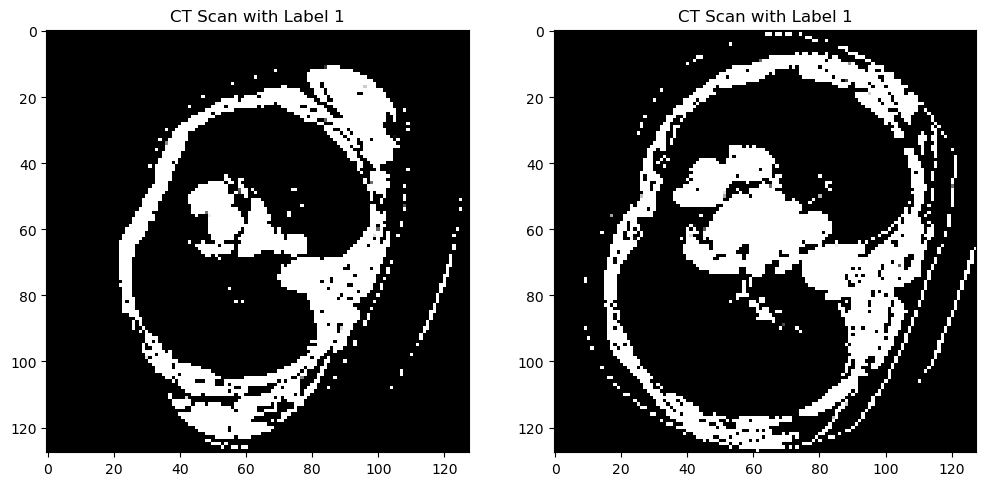

In [134]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image0 = images[0]
image1 = images[1]
print("Dimension of the CT scan is:", image.shape)
print("Label of the CT scan is:", labels[1].numpy())


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 15))

ax1.imshow(np.squeeze(image0[:, :, 30]), cmap="gray")
ax1.set_title(f"CT Scan with Label {labels[0].numpy()}")

ax2.imshow(np.squeeze(image1[:, :, 30]), cmap="gray")
ax2.set_title(f"CT Scan with Label {labels[1].numpy()}")

Since a CT scan has many slices, let's visualize a montage of the slices.

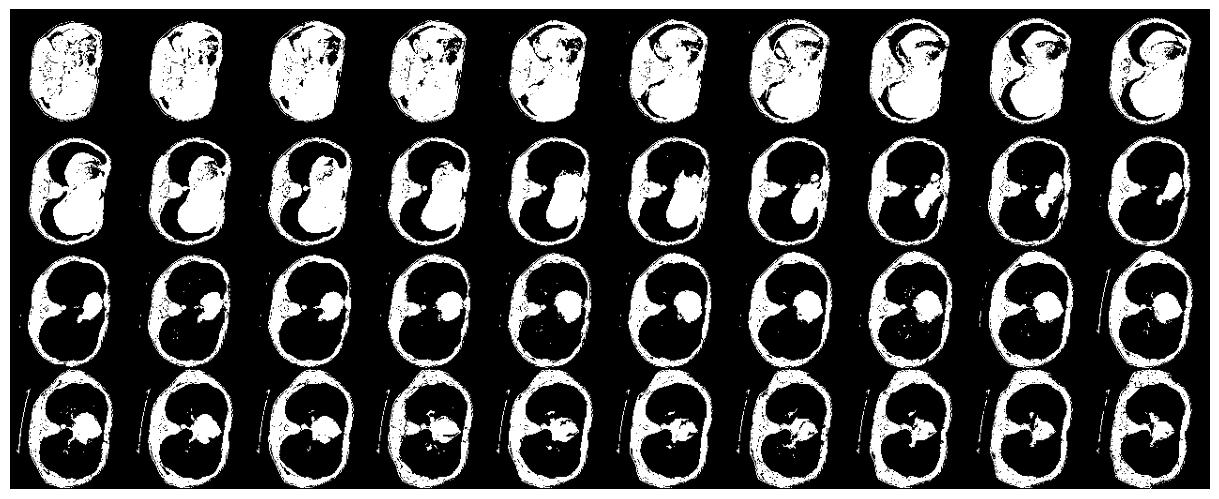

In [135]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

## Model

In [137]:
inputs = tf.keras.layers.Input((128, 128, 64,1))

x = tf.keras.layers.Conv3D(filters=64, kernel_size=3,activation='relu')(inputs)
x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv3D(filters=64, kernel_size=3,activation='relu')(inputs)
x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv3D(filters=128, kernel_size=3,activation='relu')(inputs)
x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv3D(filters=256, kernel_size=3,activation='relu')(inputs)
x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.GlobalAveragePooling3D()(x)
x = tf.keras.layers.Dense(units=512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

In [138]:
model = tf.keras.Model(inputs, outputs, name='3DCnn')

In [139]:
model.summary()

Model: "3DCnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 64,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 126, 126, 62,   │         7,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 63, 63, 31,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 63, 63, 31,     │         1,024 │
│ (BatchNormalization)            │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,289 (548.00 KB)

 Trainable params: 139,777 (546.00 KB)

 Non-trainable params: 512 (2.00 KB)

## Compile model.

In [140]:

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [141]:
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["accuracy"],
    run_eagerly=True,
)

In [145]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "3d_image_classification.keras", save_best_only=True
)

In [143]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

If Training the model gives your machine a heart attack, then train on colab or kaggle, download the model and load into the kernel, Just like me.

In [ ]:
hist = model.fit(train_dataset, validation_data=validation_dataset, epochs=100, shuffle=True, verbose=2, callbacks=[checkpoint_cb, early_stopping_cb])

## Load Saved Model

In [150]:
model = tf.keras.models.load_model('./Image-classification-CT-scans.h5')

## Make predictions on a single CT scan

In [152]:
class_names = ["normal", "abnormal"]

In [160]:
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

for score, name in zip(scores, class_names):
    print(f"This model is {(100*score)} percent confident that CT scan is {name} ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
This model is 0.0 percent confident that CT scan is normal 
This model is 100.0 percent confident that CT scan is abnormal 


In [165]:
prediction = model.predict(np.expand_dims(x_val[1], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

for score, name in zip(scores, class_names):
    print(f"This model is {(100*score)} percent confident that CT scan is {name} ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
This model is 100.0 percent confident that CT scan is normal 
This model is 0.0 percent confident that CT scan is abnormal 


In [181]:
prediction = model.predict(np.expand_dims(x_val[33], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

for score, name in zip(scores, class_names):
    print(f"This model is {(100*score)} percent confident that CT scan is {name} ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
This model is 100.0 percent confident that CT scan is normal 
This model is 0.0 percent confident that CT scan is abnormal 
